In [1]:
import numpy as np
from numpy.linalg import norm
from math import *
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from random import random
from scipy.spatial import ConvexHull
from matplotlib import path
import time


% matplotlib inline

Helper functions

In [2]:
def isCollisionFreeVertex(obstacles, xy):
    collFree = True

    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print 'collision'
            return collFree

    return collFree

In [3]:
def isCollisionFreeEdge(obstacles, closest_vert, xy):
    closest_vert = np.array(closest_vert); xy = np.array(xy)
    collFree = True
    l = norm(closest_vert - xy)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*closest_vert + t[i]*xy # calculate configuration
        collFree = isCollisionFreeVertex(obstacles, p) 
        if collFree == False: return False

    return collFree

RRT algorithm

### RRT in 3D

In [4]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [49]:
def isCollisionFreeVertex(obstacle, point):
    x,y,z = point
    dx, dy, dz = obstacle.dimensions
    x0, y0, z0 = obstacle.pose
    if abs(x-x0)<=dx/2 and abs(y-y0)<=dy/2 and abs(z-z0)<=dz/2:
        return 0
    else:
        return 1

In [50]:
def isCollisionFreeEdge(obstacle, closest_vert, p):
    closest_vert = np.array(closest_vert); p = np.array(p)
    collFree = True
    l = norm(closest_vert - p)
    map_resolution = 0.01; M = int(l / map_resolution)
    if M <= 2: M = 20
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        point = (1-t[i])*closest_vert + t[i]*p # calculate configuration
        collFree = isCollisionFreeVertex(obstacle, point) 
        if collFree == False: return False

    return collFree

In [5]:
class Node3D:
    def __init__(self):
        self.p     = [0, 0, 0]
        self.i     = 0
        self.iPrev = 0

In [6]:
def closestNode3D(rrt, p):
    distance = []
    for node in rrt:
        distance.append( sqrt((p[0] - node.p[0])**2 + (p[1] - node.p[1])**2 + (p[2] - node.p[2])**2) )
    distance = np.array(distance)
    
    dmin = min(distance)
    ind_min = distance.tolist().index(dmin)
    closest_node = rrt[ind_min]

    return closest_node

In [7]:
def plot_point3D(p, color='blue'):
    ax.scatter3D(p[0], p[1], p[2], color=color)

Reached the goal after 0.10 seconds:
Number of iterations passed: 80 / 500
RRT length:  79
Constructing the path...
Reached RRT start node


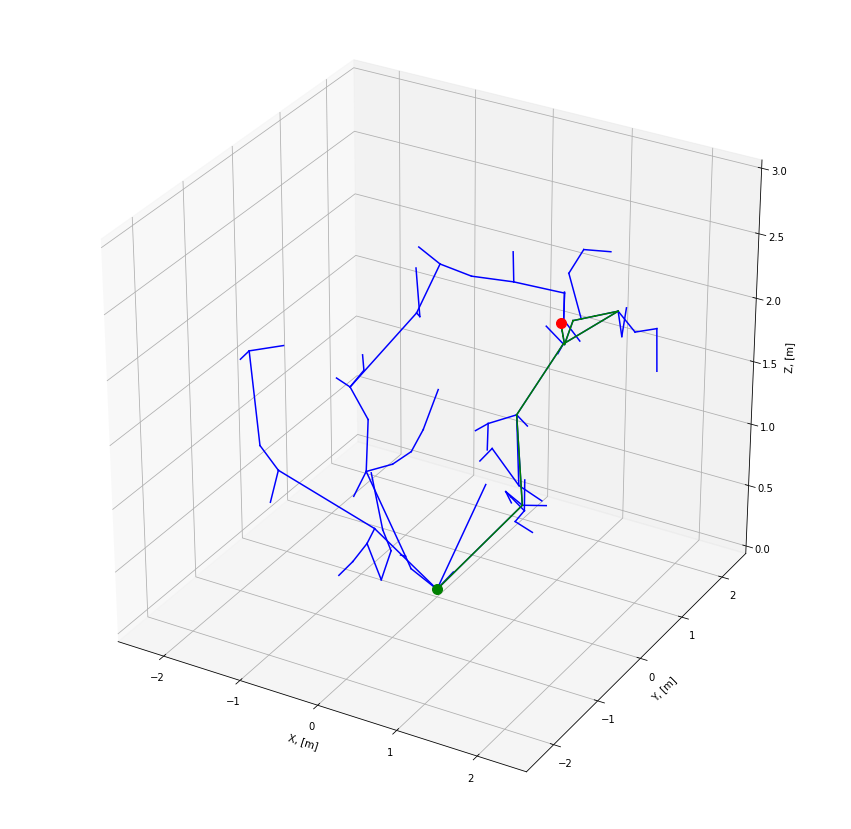

In [61]:
# Initialization
maxiters  = 500
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.05 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.40 # Extension parameter: this controls how far the RRT extends in each step.

# Start and goal positions
start = np.array([0.0, 0.0, 0.0]); ax.scatter3D(start[0], start[1], start[2], color='green', s=100)
goal =  np.array([1.0, 1.0, 2.0]);  ax.scatter3D(goal[0], goal[1], goal[2], color='red', s=100)

# Initialize RRT. The RRT will be represented as a 2 x N list of points.
# So each column represents a vertex of the tree.
rrt = []
start_node = Node3D()
start_node.p = start
start_node.i = 0
start_node.iPrev = 0
rrt.append(start_node)


# RRT algorithm
start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    # Sample point
    rnd = random()
    # With probability 0.05, sample the goal. This promotes movement to the goal.
    if rnd < 0.05:
        p = goal
    else:
        p = np.array([random()*5-2.5, random()*5-2.5, random()*3]) # Should be a 3 x 1 vector
        
    # Check if sample is collision free
    collFree = isCollisionFreeVertex(obstacle, p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

    # If it is collision free, find closest point in existing tree. 
    closest_node = closestNode3D(rrt, p)
    
    
    # Extend tree towards xy from closest_vert. Use the extension parameter
    # d defined above as your step size. In other words, the Euclidean
    # distance between new_vert and closest_vert should be d.
    new_node = Node3D()
    new_node.p = closest_node.p + d * (p - closest_node.p)
    new_node.i = len(rrt)
    new_node.iPrev = closest_node.i

#     plot_point3D(p, 'red')
#     plot_point3D(new_node.p, color='blue')
    ax.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], [closest_node.p[2], new_node.p[2]],color = 'b')

    
    # Check if new vertice is in collision
    collFree = isCollisionFreeEdge(obstacle, closest_node.p, new_node.p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue
    
    # If it is collision free, add it to tree    
    rrt.append(new_node)

    # Check if we have reached the goal
    if norm(np.array(goal) - np.array(new_node.p)) < minDistGoal:
        # Add last, goal node
        goal_node = Node3D()
        goal_node.p = goal
        goal_node.i = len(rrt)
        goal_node.iPrev = new_node.i
#         if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
#             rrt.append(goal_node)
#             P = [goal_node.p]
#         else: P = []
        end_time = time.time()
        nearGoal = True
        print ('Reached the goal after %.2f seconds:' % (end_time - start_time))

    iters += 1

print ('Number of iterations passed: %d / %d' %(iters, maxiters))
print ('RRT length: ', len(rrt))

# Path construction from RRT:
P = [goal_node.p]
print ('Constructing the path...')
i = len(rrt) - 1
while True:
    i = rrt[i].iPrev
    P.append(rrt[i].p)
    if i == 0:
        print ('Reached RRT start node')
        break
P = np.array(P)
# drawing a path from RRT
for i in range(P.shape[0]-1):
    ax.plot([P[i,0], P[i+1,0]], [P[i,1], P[i+1,1]], [P[i,2], P[i+1,2]],color = 'g')
    
    

# Add Obstacles

In [70]:
class Parallelepiped:
    def __init__(self):
        self.dimensions = [0,0,0]
        self.pose = [0,0,0]
        self.verts = np.zeros([6,4,3])
        
    def vertixes(self):
        dx = self.dimensions[0]
        dy = self.dimensions[1]
        dz = self.dimensions[2]
        C = np.array(self.pose)

        Z = np.array([[-dx/2, -dy/2, -dz/2],
                      [dx/2, -dy/2, -dz/2 ],
                      [dx/2, dy/2, -dz/2],
                      [-dx/2, dy/2, -dz/2],
                      [-dx/2, -dy/2, dz/2],
                      [dx/2, -dy/2, dz/2 ],
                      [dx/2, dy/2, dz/2],
                      [-dx/2, dy/2, dz/2]])
        Z += C

        # list of sides' polygons of figure
        verts = [ [Z[0], Z[1], Z[2], Z[3]],
                  [Z[4], Z[5], Z[6], Z[7]], 
                  [Z[0], Z[1], Z[5], Z[4]], 
                  [Z[2], Z[3], Z[7], Z[6]], 
                  [Z[1], Z[2], Z[6], Z[5]],
                  [Z[4], Z[7], Z[3], Z[0]] ]

        # plot sides
    #     if plot:
    #         ax.add_collection3d(Poly3DCollection(verts, facecolors='b', linewidths=1, edgecolors='k', alpha=.25))
    #         plt.show()
        return verts

In [71]:
def draw_parallelepiped(verts):
    ax.add_collection3d(Poly3DCollection(verts, facecolors='b', linewidths=1, edgecolors='k', alpha=.25))

Reached the goal after 0.20 seconds:
Number of iterations passed: 183 / 500
RRT length:  176
Constructing the path...
Reached RRT start node


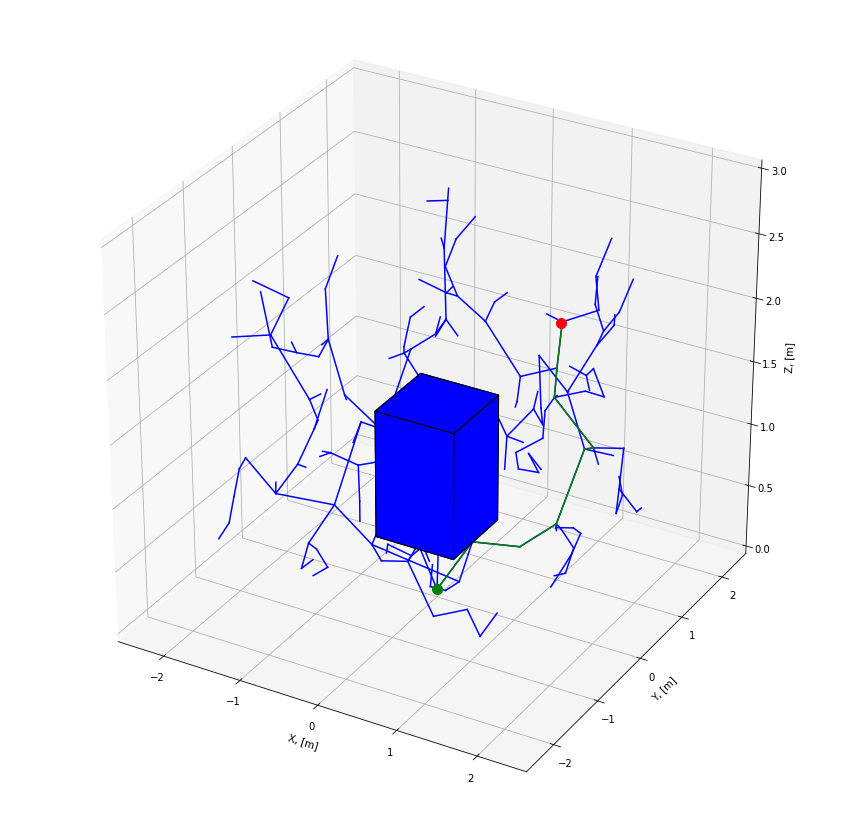

In [73]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlabel('X, [m]')
ax.set_ylabel('Y, [m]')
ax.set_zlabel('Z, [m]')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_zlim([0.0, 3.0])

obstacle = Parallelepiped()
obstacle.dimensions = [1,1,1]
obstacle.pose = [0,0,1]
draw_parallelepiped(obstacle.vertixes())


# RRT Initialization
maxiters  = 500
nearGoal = False # This will be set to true if goal has been reached
minDistGoal = 0.05 # Convergence criterion: success when the tree reaches within 0.25 in distance from the goal.
d = 0.40 # Extension parameter: this controls how far the RRT extends in each step.

# Start and goal positions
start = np.array([0.0, 0.0, 0.0]); ax.scatter3D(start[0], start[1], start[2], color='green', s=100)
goal =  np.array([1.0, 1.0, 2.0]);  ax.scatter3D(goal[0], goal[1], goal[2], color='red', s=100)

# Initialize RRT. The RRT will be represented as a 2 x N list of points.
# So each column represents a vertex of the tree.
rrt = []
start_node = Node3D()
start_node.p = start
start_node.i = 0
start_node.iPrev = 0
rrt.append(start_node)


# RRT algorithm
start_time = time.time()
iters = 0
while not nearGoal and iters < maxiters:
    # Sample point
    rnd = random()
    # With probability 0.05, sample the goal. This promotes movement to the goal.
    if rnd < 0.05:
        p = goal
    else:
        p = np.array([random()*5-2.5, random()*5-2.5, random()*3]) # Should be a 3 x 1 vector
        
    # Check if sample is collision free
    collFree = isCollisionFreeVertex(obstacle, p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue

    # If it is collision free, find closest point in existing tree. 
    closest_node = closestNode3D(rrt, p)
    
    
    # Extend tree towards xy from closest_vert. Use the extension parameter
    # d defined above as your step size. In other words, the Euclidean
    # distance between new_vert and closest_vert should be d.
    new_node = Node3D()
    new_node.p = closest_node.p + d * (p - closest_node.p)
    new_node.i = len(rrt)
    new_node.iPrev = closest_node.i

#     plot_point3D(p, 'red')
#     plot_point3D(new_node.p, color='blue')
    ax.plot([closest_node.p[0], new_node.p[0]], [closest_node.p[1], new_node.p[1]], [closest_node.p[2], new_node.p[2]],color = 'b')

    
    # Check if new vertice is in collision
    collFree = isCollisionFreeEdge(obstacle, closest_node.p, new_node.p)
    # If it's not collision free, continue with loop
    if not collFree:
        iters += 1
        continue
    
    # If it is collision free, add it to tree    
    rrt.append(new_node)

    # Check if we have reached the goal
    if norm(np.array(goal) - np.array(new_node.p)) < minDistGoal:
        # Add last, goal node
        goal_node = Node3D()
        goal_node.p = goal
        goal_node.i = len(rrt)
        goal_node.iPrev = new_node.i
#         if isCollisionFreeEdge(obstacles, new_node.p, goal_node.p):
#             rrt.append(goal_node)
#             P = [goal_node.p]
#         else: P = []
        end_time = time.time()
        nearGoal = True
        print ('Reached the goal after %.2f seconds:' % (end_time - start_time))

    iters += 1

print ('Number of iterations passed: %d / %d' %(iters, maxiters))
print ('RRT length: ', len(rrt))

# Path construction from RRT:
P = [goal_node.p]
print ('Constructing the path...')
i = len(rrt) - 1
while True:
    i = rrt[i].iPrev
    P.append(rrt[i].p)
    if i == 0:
        print ('Reached RRT start node')
        break
P = np.array(P)
# drawing a path from RRT
for i in range(P.shape[0]-1):
    ax.plot([P[i,0], P[i+1,0]], [P[i,1], P[i+1,1]], [P[i,2], P[i+1,2]],color = 'g')
    
    